In [1]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from model_file import *
from vce_dataloader import getBinaryDataLoader, getAllDataLoader, getNaryDataLoader, visualize_batch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub

In [3]:
# model = getModel("resnet50")
classifier = getModel("vitcnn")

In [4]:
model = classifier(cnnmodel = 'resnet34', num_classes=2)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 148MB/s]


ViTCNNModel(
  (cnn_branch): CNNBranch(
    (cnn): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Batc

Order of classes:
* Normal
* Erosion
* Polyp
* Angioectasia
* Bleeding
* Lymphangiectasia
* Foreign Body
* Erythema
* Ulcer
* Worms

In [5]:
train_path = "/kaggle/input/vce-augmented-dataset/training"
val_path = "/kaggle/input/vce-augmented-dataset/validation"

In [6]:
train_transform = transforms.Compose([#transforms.RandomHorizontalFlip(p=0.7),
                                     #transforms.RandomVerticalFlip(p=0.7),
                                     #transforms.RandomRotation(15),
                                     
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor()
                              ])


val_transform= transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

In [7]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the same device as model
            labels = labels.to(device)  # Move labels to the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)

# Binary

In [8]:
target_class_names = ["Normal"]
binDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
binDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [9]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [11]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
model = model.to(device)

In [13]:
num_epochs = 2

In [14]:

for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in binDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        if(i%100 == 0):
            print(f"Bin - [{i}/{len(binDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in binDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Bin - [0/1854] train loss : 0.6956685185432434
Bin - [100/1854] train loss : 0.41682738065719604
Bin - [200/1854] train loss : 0.35616111755371094
Bin - [300/1854] train loss : 0.2740109860897064
Bin - [400/1854] train loss : 0.453188955783844
Bin - [500/1854] train loss : 0.32174763083457947
Bin - [600/1854] train loss : 0.537212073802948
Bin - [700/1854] train loss : 0.2197696566581726
Bin - [800/1854] train loss : 0.16997098922729492
Bin - [900/1854] train loss : 0.1642429381608963
Bin - [1000/1854] train loss : 0.3117736577987671
Bin - [1100/1854] train loss : 0.2945491671562195
Bin - [1200/1854] train loss : 0.3117493987083435
Bin - [1300/1854] train loss : 0.5735013484954834
Bin - [1400/1854] train loss : 0.3528743088245392
Bin - [1500/1854] train loss : 0.3040368854999542
Bin - [1600/1854] train loss : 0.2374483048915863
Bin - [1700/1854] train loss : 0.29846492409706116
Bin - [1800/1854] train loss : 0.18514926731586456
Epoch [1/2]
Train Loss: 0.3286, Train Accuracy: 0.8610
Val

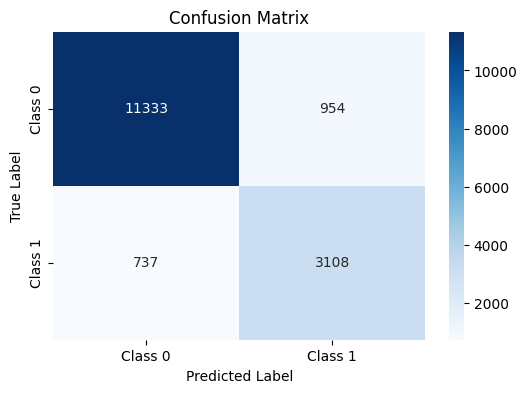

In [15]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, binDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
del binDL_train
del binDL_val

# Ternary

In [17]:
target_class_names = ["Normal","Erosion"]
terDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
terDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [18]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [20]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
model = model.to(device)

In [22]:
num_epochs = 3

In [23]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in terDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Ter - [{i}/{len(terDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in terDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Ter - [0/1854] train loss : 4.554413795471191
Ter - [100/1854] train loss : 0.31210559606552124
Ter - [200/1854] train loss : 0.34286752343177795
Ter - [300/1854] train loss : 0.37414515018463135
Ter - [400/1854] train loss : 0.3527696430683136
Ter - [500/1854] train loss : 0.16425377130508423
Ter - [600/1854] train loss : 0.30784130096435547
Ter - [700/1854] train loss : 0.5374098420143127
Ter - [800/1854] train loss : 0.6456241607666016
Ter - [900/1854] train loss : 0.3061003088951111
Ter - [1000/1854] train loss : 0.27333033084869385
Ter - [1100/1854] train loss : 0.26992738246917725
Ter - [1200/1854] train loss : 0.5368653535842896
Ter - [1300/1854] train loss : 0.5027282238006592
Ter - [1400/1854] train loss : 0.3555077612400055
Ter - [1500/1854] train loss : 0.23667189478874207
Ter - [1600/1854] train loss : 0.328048974275589
Ter - [1700/1854] train loss : 0.29556217789649963
Ter - [1800/1854] train loss : 0.4661110043525696
Epoch [1/3]
Train Loss: 0.4293, Train Accuracy: 0.8258


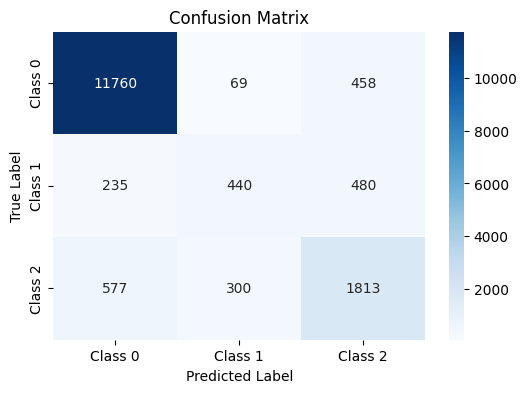

In [24]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, terDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
del terDL_train
del terDL_val

# Quaternary

In [26]:
target_class_names = ["Normal","Erosion","Polyp"]
quatDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
quatDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [27]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [29]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [30]:
model = model.to(device)

In [31]:
num_epochs = 4

In [32]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in quatDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Quat - [{i}/{len(quatDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in quatDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Quat - [0/1854] train loss : 2.944370746612549
Quat - [100/1854] train loss : 0.28651514649391174
Quat - [200/1854] train loss : 0.42839571833610535
Quat - [300/1854] train loss : 0.6049632430076599
Quat - [400/1854] train loss : 0.26265349984169006
Quat - [500/1854] train loss : 0.2647901773452759
Quat - [600/1854] train loss : 0.4779742360115051
Quat - [700/1854] train loss : 0.3404095470905304
Quat - [800/1854] train loss : 0.28797778487205505
Quat - [900/1854] train loss : 0.6750035285949707
Quat - [1000/1854] train loss : 0.19298341870307922
Quat - [1100/1854] train loss : 0.12836982309818268
Quat - [1200/1854] train loss : 0.30633795261383057
Quat - [1300/1854] train loss : 0.3009907007217407
Quat - [1400/1854] train loss : 0.18687254190444946
Quat - [1500/1854] train loss : 0.40669822692871094
Quat - [1600/1854] train loss : 0.3743015229701996
Quat - [1700/1854] train loss : 0.2857259213924408
Quat - [1800/1854] train loss : 0.4070412218570709
Epoch [1/4]
Train Loss: 0.3760, Tra

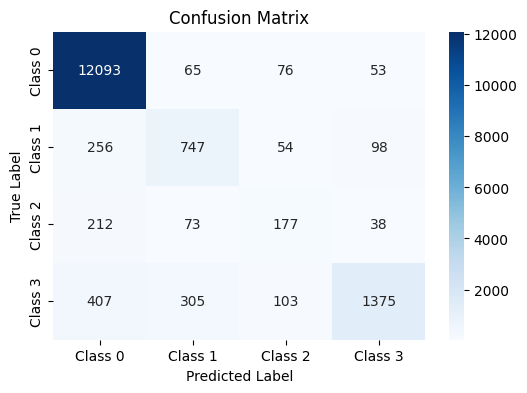

In [33]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, quatDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [34]:
del quatDL_train
del quatDL_val

# Pentanary

In [35]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia"]
pentDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
pentDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [36]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [38]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
model = model.to(device)

In [40]:
num_epochs = 5

In [41]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in pentDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Pent - [{i}/{len(pentDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in pentDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Pent - [0/1854] train loss : 1.5992380380630493
Pent - [100/1854] train loss : 0.33215099573135376
Pent - [200/1854] train loss : 0.25819435715675354
Pent - [300/1854] train loss : 0.3786030411720276
Pent - [400/1854] train loss : 0.24774885177612305
Pent - [500/1854] train loss : 0.2850338816642761
Pent - [600/1854] train loss : 0.1788017898797989
Pent - [700/1854] train loss : 0.17530155181884766
Pent - [800/1854] train loss : 0.3109706938266754
Pent - [900/1854] train loss : 0.2376061975955963
Pent - [1000/1854] train loss : 0.2233526110649109
Pent - [1100/1854] train loss : 0.4158346652984619
Pent - [1200/1854] train loss : 0.2600260078907013
Pent - [1300/1854] train loss : 0.37166354060173035
Pent - [1400/1854] train loss : 0.1826564222574234
Pent - [1500/1854] train loss : 0.32847315073013306
Pent - [1600/1854] train loss : 0.32758232951164246
Pent - [1700/1854] train loss : 0.5639602541923523
Pent - [1800/1854] train loss : 0.19307130575180054
Epoch [1/5]
Train Loss: 0.3160, Tra

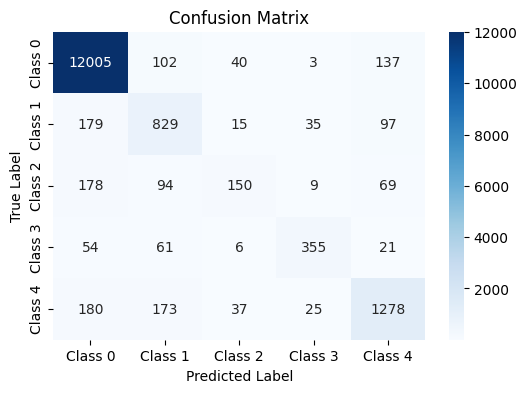

In [42]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, pentDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
del pentDL_train
del pentDL_val

# Senary

In [44]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding"]
senDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
senDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [45]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [47]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [48]:
model = model.to(device)

In [49]:
num_epochs = 6

In [50]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in senDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"[Sen - {i}/{len(senDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in senDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

[Sen - 0/1854] train loss : 2.7347681522369385
[Sen - 100/1854] train loss : 0.19143643975257874
[Sen - 200/1854] train loss : 0.34445124864578247
[Sen - 300/1854] train loss : 0.3164409399032593
[Sen - 400/1854] train loss : 0.12631644308567047
[Sen - 500/1854] train loss : 0.2194020003080368
[Sen - 600/1854] train loss : 0.24291490018367767
[Sen - 700/1854] train loss : 0.40163519978523254
[Sen - 800/1854] train loss : 0.5414685606956482
[Sen - 900/1854] train loss : 0.046343039721250534
[Sen - 1000/1854] train loss : 0.38265910744667053
[Sen - 1100/1854] train loss : 0.23654870688915253
[Sen - 1200/1854] train loss : 0.337266743183136
[Sen - 1300/1854] train loss : 0.14360153675079346
[Sen - 1400/1854] train loss : 0.17572914063930511
[Sen - 1500/1854] train loss : 0.39262622594833374
[Sen - 1600/1854] train loss : 0.20935966074466705
[Sen - 1700/1854] train loss : 0.3284570872783661
[Sen - 1800/1854] train loss : 0.11341820657253265
Epoch [1/6]
Train Loss: 0.2597, Train Accuracy: 0

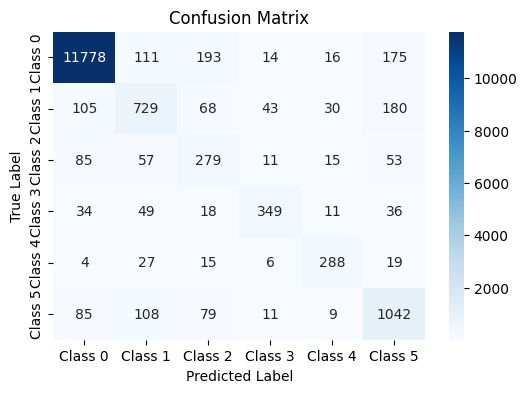

In [51]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, senDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [52]:
del senDL_train
del senDL_val

# Septenary

In [53]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia"]
septDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
septDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [54]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [56]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
model = model.to(device)

In [58]:
num_epochs = 7

In [59]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in septDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Sept - [{i}/{len(septDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in septDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Sept - [0/1854] train loss : 6.346708297729492
Sept - [100/1854] train loss : 0.4122444987297058
Sept - [200/1854] train loss : 0.34228163957595825
Sept - [300/1854] train loss : 0.09559797495603561
Sept - [400/1854] train loss : 0.4585431218147278
Sept - [500/1854] train loss : 0.14145693182945251
Sept - [600/1854] train loss : 0.12865498661994934
Sept - [700/1854] train loss : 0.08432269096374512
Sept - [800/1854] train loss : 0.2753944396972656
Sept - [900/1854] train loss : 0.2220844179391861
Sept - [1000/1854] train loss : 0.08810113370418549
Sept - [1100/1854] train loss : 0.6582210659980774
Sept - [1200/1854] train loss : 0.2536637783050537
Sept - [1300/1854] train loss : 0.2211752086877823
Sept - [1400/1854] train loss : 0.14532503485679626
Sept - [1500/1854] train loss : 0.12741632759571075
Sept - [1600/1854] train loss : 0.1730297952890396
Sept - [1700/1854] train loss : 0.3877929449081421
Sept - [1800/1854] train loss : 0.3466654121875763
Epoch [1/7]
Train Loss: 0.2179, Trai

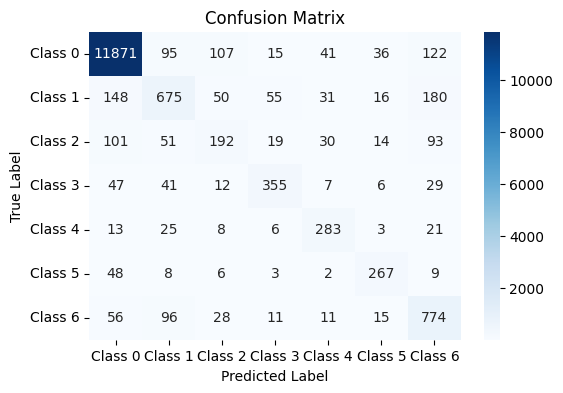

In [60]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, septDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [61]:
del septDL_train
del septDL_val

# Octal

In [62]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body"]
octDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
octDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [63]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [65]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
model = model.to(device)

In [67]:
num_epochs = 8

In [68]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in octDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Oct - [{i}/{len(octDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in octDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Oct - [0/1854] train loss : 6.224739074707031
Oct - [100/1854] train loss : 0.16822277009487152
Oct - [200/1854] train loss : 0.20318378508090973
Oct - [300/1854] train loss : 0.0871099978685379
Oct - [400/1854] train loss : 0.05976158007979393
Oct - [500/1854] train loss : 0.13215407729148865
Oct - [600/1854] train loss : 0.2825140357017517
Oct - [700/1854] train loss : 0.031520433723926544
Oct - [800/1854] train loss : 0.30419397354125977
Oct - [900/1854] train loss : 0.021790998056530952
Oct - [1000/1854] train loss : 0.00549918320029974
Oct - [1100/1854] train loss : 0.08136612176895142
Oct - [1200/1854] train loss : 0.023986145853996277
Oct - [1300/1854] train loss : 0.004656643606722355
Oct - [1400/1854] train loss : 0.10979585349559784
Oct - [1500/1854] train loss : 0.15932205319404602
Oct - [1600/1854] train loss : 0.14002574980258942
Oct - [1700/1854] train loss : 0.19162069261074066
Oct - [1800/1854] train loss : 0.05519023537635803
Epoch [1/8]
Train Loss: 0.1555, Train Accur

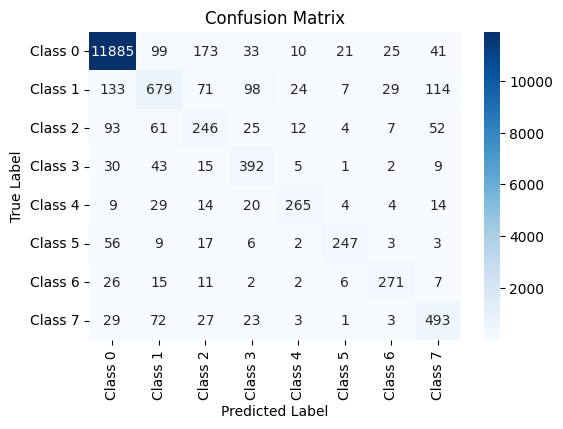

In [69]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, octDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [70]:
del octDL_train
del octDL_val

# Nonary

In [71]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema"]
nonDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
nonDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [72]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [74]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
model = model.to(device)

In [76]:
num_epochs = 9

In [77]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in nonDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Non - [{i}/{len(nonDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in nonDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Non - [0/1854] train loss : 7.930497169494629
Non - [100/1854] train loss : 0.12203104794025421
Non - [200/1854] train loss : 0.058663271367549896
Non - [300/1854] train loss : 0.06999866664409637
Non - [400/1854] train loss : 0.0573962926864624
Non - [500/1854] train loss : 0.104415662586689
Non - [600/1854] train loss : 0.11399053782224655
Non - [700/1854] train loss : 0.09772896021604538
Non - [800/1854] train loss : 0.1707434356212616
Non - [900/1854] train loss : 0.003425853792577982
Non - [1000/1854] train loss : 0.005134888458997011
Non - [1100/1854] train loss : 0.050474248826503754
Non - [1200/1854] train loss : 0.0030702920630574226
Non - [1300/1854] train loss : 0.06182710453867912
Non - [1400/1854] train loss : 0.0037032647524029016
Non - [1500/1854] train loss : 0.12814372777938843
Non - [1600/1854] train loss : 0.1292719841003418
Non - [1700/1854] train loss : 0.07901962101459503
Non - [1800/1854] train loss : 0.04058294743299484
Epoch [1/9]
Train Loss: 0.1121, Train Accu

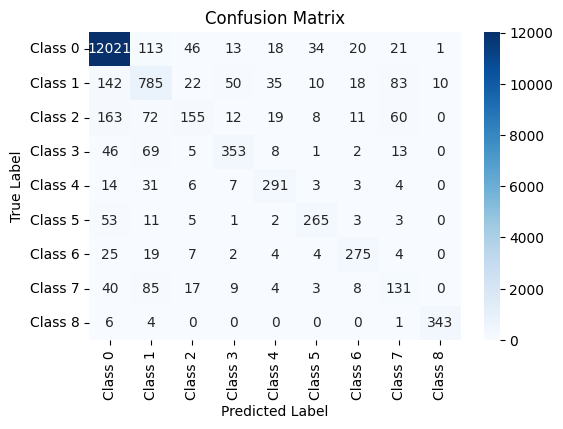

In [78]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, nonDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [79]:
del nonDL_train
del nonDL_val

# Decimal

In [80]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema","Ulcer"]
decDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
decDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [81]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [83]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [84]:
model = model.to(device)

In [85]:
num_epochs = 10

In [86]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in decDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Dec - [{i}/{len(decDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in decDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Dec - [0/1854] train loss : 11.292646408081055
Dec - [100/1854] train loss : 0.10403469949960709
Dec - [200/1854] train loss : 0.1044764593243599
Dec - [300/1854] train loss : 0.01773829385638237
Dec - [400/1854] train loss : 0.04145343601703644
Dec - [500/1854] train loss : 0.0028802084270864725
Dec - [600/1854] train loss : 0.004695962183177471
Dec - [700/1854] train loss : 0.14364312589168549
Dec - [800/1854] train loss : 0.011601705104112625
Dec - [900/1854] train loss : 0.02902253158390522
Dec - [1000/1854] train loss : 0.0933200791478157
Dec - [1100/1854] train loss : 0.40354734659194946
Dec - [1200/1854] train loss : 0.1235252395272255
Dec - [1300/1854] train loss : 0.022457996383309364
Dec - [1400/1854] train loss : 0.3118397295475006
Dec - [1500/1854] train loss : 0.0008608946809545159
Dec - [1600/1854] train loss : 0.14084415137767792
Dec - [1700/1854] train loss : 0.0032545782160013914
Dec - [1800/1854] train loss : 0.007655496709048748
Epoch [1/10]
Train Loss: 0.0927, Train

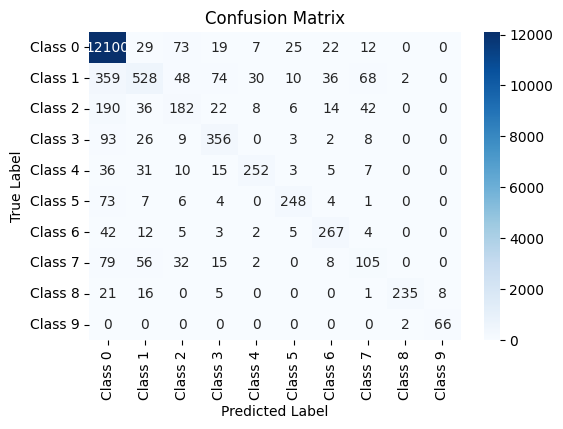

In [87]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, decDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [88]:
del decDL_train
del decDL_val

# Final

In [89]:
target_class_names = ["Normal","Erosion","Polyp", "Angioectasia", "Bleeding", "Lymphangiectasia", "Foreign Body", "Erythema","Ulcer","Worms"]
finDL_train = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=train_path, 
                          batch_size=32, trans = train_transform)
finDL_val = getNaryDataLoader(target_class_names=target_class_names, path_to_dataset=val_path, 
                          batch_size=32, trans = val_transform)

In [90]:
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(in_features=num_ftrs, out_features=len(target_class_names)+1)
model.set_classification_head(len(target_class_names)+1)

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [92]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [93]:
model = model.to(device)

In [94]:
num_epochs = 15

In [95]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    i = 0
    for inputs, labels in finDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
        if(i%100 == 0):
            print(f"Fin - [{i}/{len(finDL_train)}] train loss : {loss.item()}")
        i = i+1
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in finDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Fin - [0/1854] train loss : 7.848100185394287
Fin - [100/1854] train loss : 0.0025589449796825647
Fin - [200/1854] train loss : 0.0014016241766512394
Fin - [300/1854] train loss : 0.0008581134025007486
Fin - [400/1854] train loss : 0.026245402172207832
Fin - [500/1854] train loss : 0.00044592490303330123
Fin - [600/1854] train loss : 0.029489772394299507
Fin - [700/1854] train loss : 0.015455886721611023
Fin - [800/1854] train loss : 0.0013693837681785226
Fin - [900/1854] train loss : 0.01248049084097147
Fin - [1000/1854] train loss : 0.005645812023431063
Fin - [1100/1854] train loss : 0.06642767786979675
Fin - [1200/1854] train loss : 0.10909957438707352
Fin - [1300/1854] train loss : 0.11583314090967178
Fin - [1400/1854] train loss : 0.005502718035131693
Fin - [1500/1854] train loss : 0.031082913279533386
Fin - [1600/1854] train loss : 0.00016097581828944385
Fin - [1700/1854] train loss : 0.0024417368695139885
Fin - [1800/1854] train loss : 0.0002281781635247171
Epoch [1/15]
Train Lo

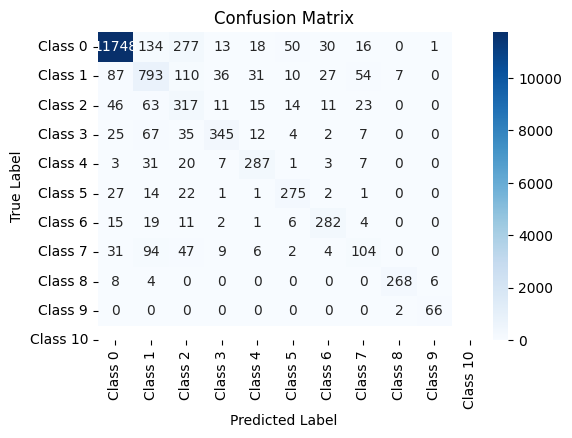

In [96]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, finDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)
class_names = [f'Class {i}' for i in range(len(target_class_names)+1)]
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [97]:
del finDL_train
del finDL_val

In [98]:
final_path = "checkpoint.pth"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, final_path)